In [2]:
# Developing test script to create 2d histogram and detect x and y shift between two roughly identical images.

import numpy as np
import matplotlib.pyplot as plt

import scipy.ndimage as nd

Working on method that can detect temporal and range shift between high- and low-gain channels (shifts in in x and y). I assume this is constant between the channels because the difference in range is their differential optical path length and the difference in time might be because of differential start times for the acquisition of each channel (i.e., I've noticed that one channel starts recording signal before the other one). The translation detection is based on the phase correlation technique:

Given a signal $g_1[n,m]$ and $g_2[n,m]=g_1[n+\Delta x, m+\Delta y]$, then
$$G_1[u,v]=\mathcal{F}\{g_1[n,m]\}$$
$$G_2[u,v]=\mathcal{F}\{g_2[n,m]\}=G_1[u,v]\exp\left[-j2\pi\left(\frac{u}{M}\Delta x+\frac{v}{N}\Delta y\right)\right]$$
where $\mathcal{F}$ is the discrete fourier transform operator and M and N are the discrete dimension lengths. The phase correlator is defined as:
$$R[u,v]\triangleq\frac{G_1[u,v]G_2^*[u,v]}{|G_1[u,v]G_2^*[u,v]|}$$
$$R[u,v]=\exp\left[+j2\pi\left(\frac{u}{M}\Delta x+\frac{v}{N}\Delta y\right)\right]$$
The spatial domain equivalent is found
$$r[n,m]=\mathcal{F}^{-1}\{R[u,v]\}=\delta(n+\Delta x, m+\Delta y)$$
where $\delta[n,m]$ is the discrete dirac delta function.

In [3]:
def gaussian_2D(X, Y, A, mu_x, mu_y, sig_x, sig_y, b):
    Z = A * np.exp(-((X - mu_x) / sig_x)**2) * np.exp(-((Y - mu_y)/sig_y)**2) + b
    return Z

In [4]:
nx, ny = (200, 200)
x = np.linspace(0, nx, nx)
y = np.linspace(0, ny, ny)
xv, yv = np.meshgrid(x, y)

In [5]:
A = 1000
mu_x = nx // 5
mu_y = ny // 4
sig_x = 2
sig_y = 2
b = 2.5

z1 = gaussian_2D(xv, yv, A, mu_x, mu_y, sig_x, sig_y, b)

In [6]:
n_sig = 4
noise1 = np.abs(np.random.normal(loc=0.0, scale=n_sig, size=z1.shape))

z1_noisy = z1 + noise1

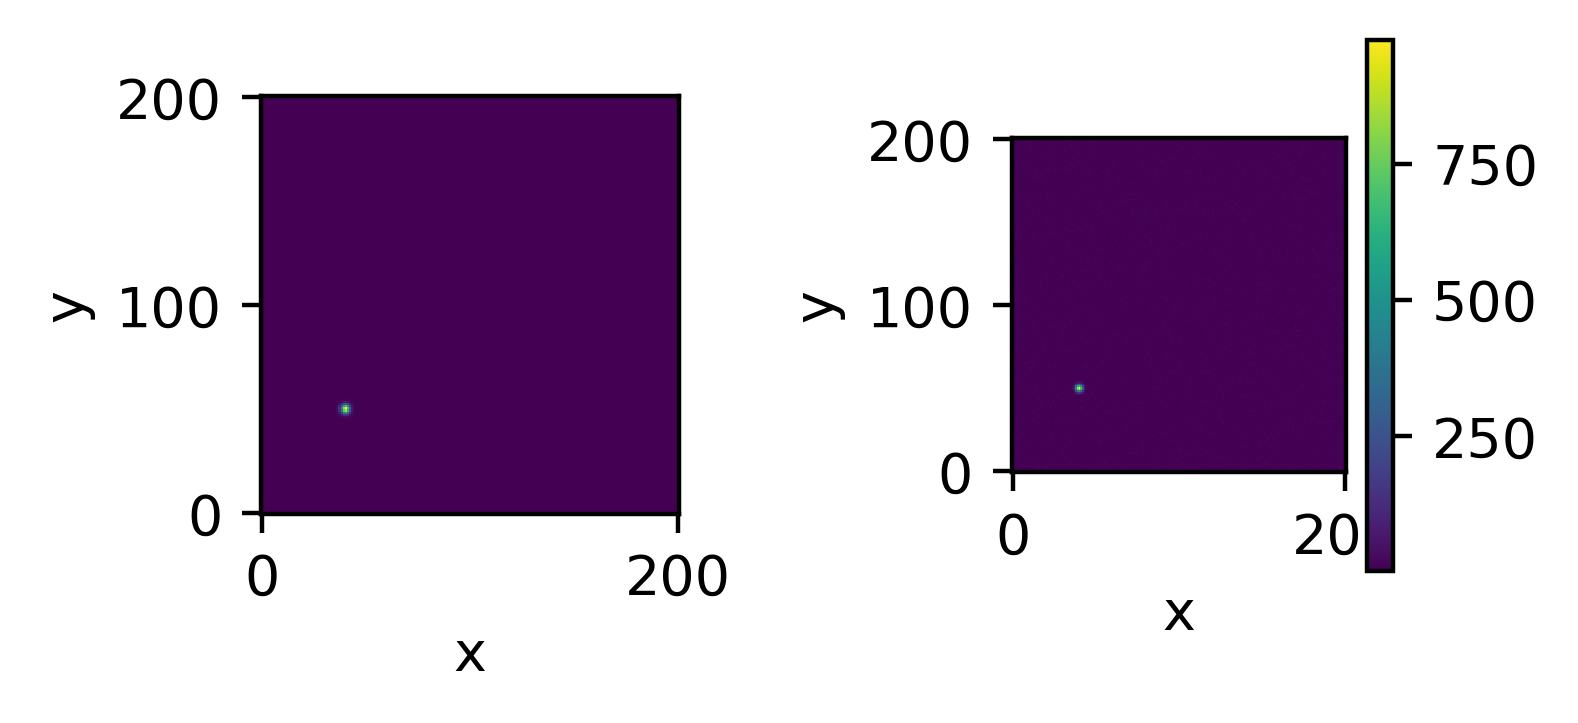

In [7]:
fig = plt.figure(figsize=(4,2), dpi=400)
ax1 = fig.add_subplot(121)
mesh1_z1 = ax1.pcolormesh(x, y, z1, vmin=0, vmax=np.max(z1_noisy))
ax1.set_xlabel('x')
ax1.set_ylabel('y')
# cbar = fig.colorbar(mesh1, ax=ax1)
plt.gca().set_aspect('equal', adjustable='box')  # force 1:1 scaling

ax2 = fig.add_subplot(122)
mesh2_z1 = ax2.pcolormesh(x, y, z1_noisy)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
cbar = fig.colorbar(mesh2_z1, ax=ax2)
plt.gca().set_aspect('equal', adjustable='box')  # force 1:1 scaling
plt.tight_layout()
plt.show()

In [8]:
shift_x = nx // 10  # x shift in pixels
shift_y = ny // 10  # y shift in pixels

z2 = np.roll(z1, shift=(shift_x, shift_y), axis=(0, 1))
z2 /= 100

noise2 = np.abs(np.random.normal(loc=0.0, scale=n_sig, size=z1.shape))
z2_noisy = z2 + noise2

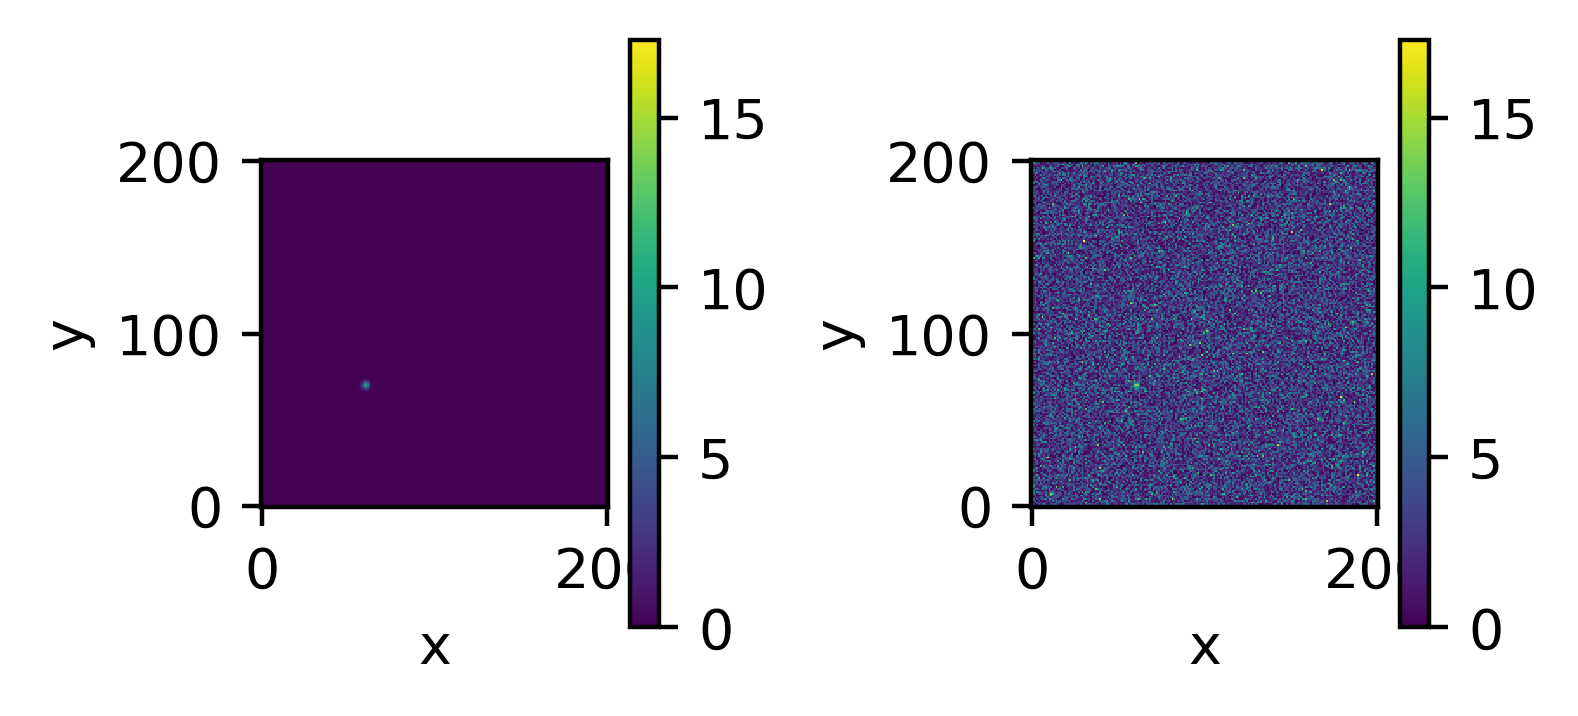

In [9]:
fig = plt.figure(figsize=(4,2), dpi=400)
ax1 = fig.add_subplot(121)
mesh1_z2 = ax1.pcolormesh(x, y, z2, vmin=0, vmax=np.max(z2_noisy))
ax1.set_xlabel('x')
ax1.set_ylabel('y')
cbar = fig.colorbar(mesh1_z2, ax=ax1)
plt.gca().set_aspect('equal', adjustable='box')  # force 1:1 scaling

ax2 = fig.add_subplot(122)
mesh2_z2 = ax2.pcolormesh(x, y, z2_noisy, vmin=0, vmax=np.max(z2_noisy))
ax2.set_xlabel('x')
ax2.set_ylabel('y')
cbar = fig.colorbar(mesh2_z2, ax=ax2)
plt.gca().set_aspect('equal', adjustable='box')  # force 1:1 scaling
plt.tight_layout()
plt.show()

In [10]:
Z1 = np.fft.fft2(z1)
Z2 = np.fft.fft2(z2)

R = (Z1 * np.conj(Z2)) / (np.abs(Z1 * np.conj(Z2)))

r = np.fft.ifft2(R)
r = np.fft.fftshift(r)

x_shift = np.arange(-nx // 2, nx // 2, 1)
y_shift = np.arange(-nx // 2, nx // 2, 1)

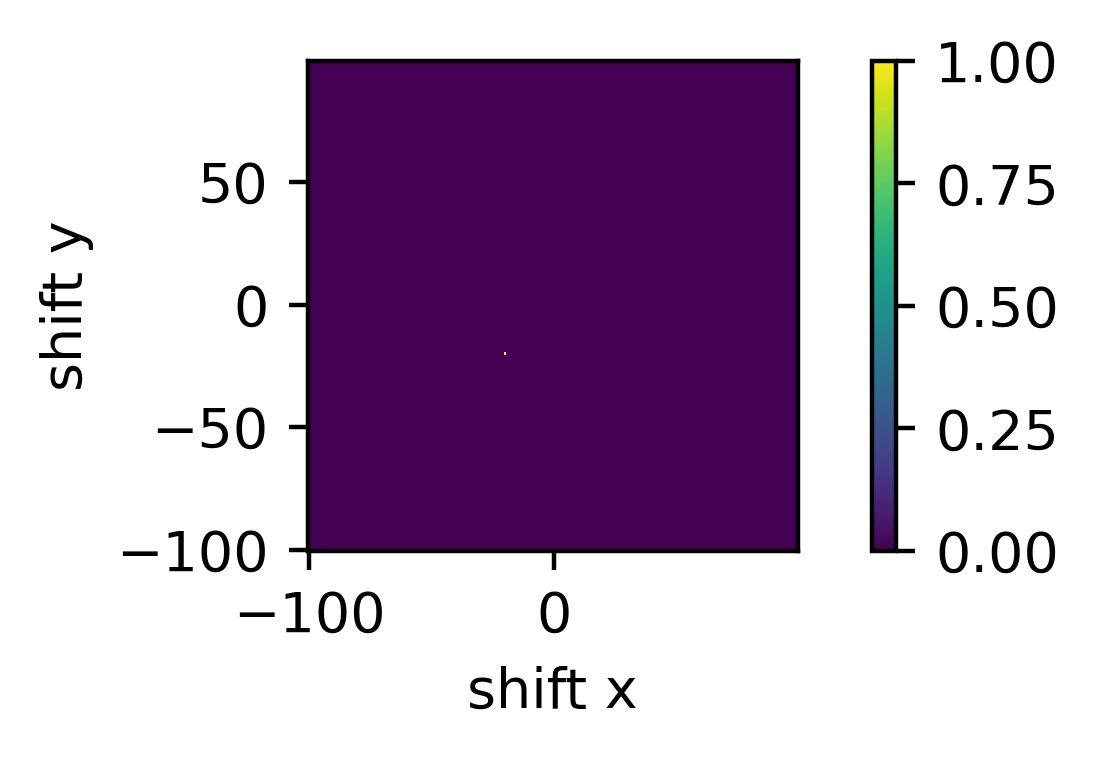

In [11]:
fig = plt.figure(figsize=(4,2), dpi=400)
ax1 = fig.add_subplot(111)
mesh1 = ax1.pcolormesh(x_shift, y_shift, np.abs(r))fi
ax1.set_xlabel('shift x')
ax1.set_ylabel('shift y')
cbar = fig.colorbar(mesh1, ax=ax1)
plt.gca().set_aspect('equal', adjustable='box')  # force 1:1 scaling
plt.tight_layout()
plt.show()


In [12]:
max_idx = np.unravel_index(np.argmax(r), r.shape)
print("Peak location (row, col):", max_idx)

dy = (max_idx[0] - nx // 2) * -1
dx = (max_idx[1] - ny // 2) * -1 
print('\nEpstimated shift X: {} pix\nEstimated shift Y: {} pix'.format(dx, dy))
print('\nTrue shift X: {} pix\nTrue shift Y: {} pix'.format(shift_x, shift_y))

Peak location (row, col): (80, 80)

Estimated shift X: 20 pix
Estimated shift Y: 20 pix

True shift X: 20 pix
True shift Y: 20 pix


In [644]:
# Now estimation using noisy images

Z1_noisy = np.fft.fft2(z1_noisy)
Z2_noisy = np.fft.fft2(z2_noisy)

R_n = (Z1_noisy * np.conj(Z2_noisy)) / (np.abs(Z1_noisy * np.conj(Z2_noisy)))

r_n = np.fft.ifft2(R_n)
r_n = np.fft.fftshift(r_n)

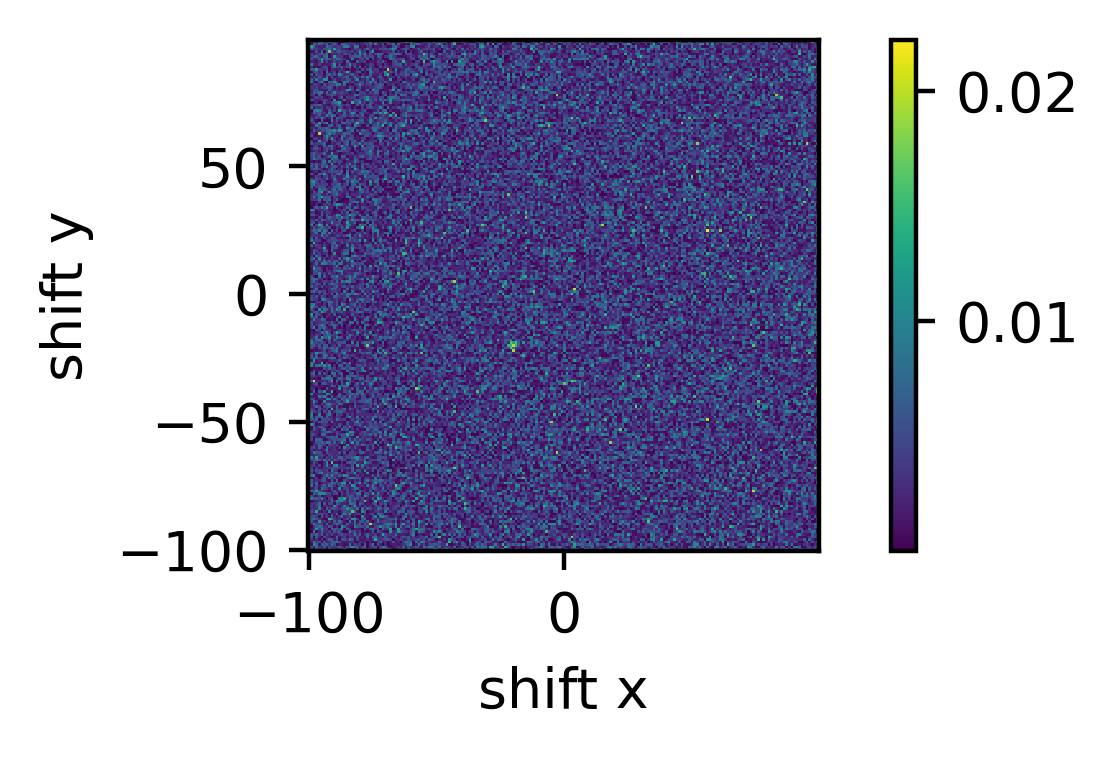

In [645]:
fig = plt.figure(figsize=(4,2), dpi=400)
ax1 = fig.add_subplot(111)
mesh1 = ax1.pcolormesh(x_shift, y_shift, np.abs(r_n))
ax1.set_xlabel('shift x')
ax1.set_ylabel('shift y')
cbar = fig.colorbar(mesh1, ax=ax1)
plt.gca().set_aspect('equal', adjustable='box')  # force 1:1 scaling
plt.tight_layout()
plt.show()


In [646]:
max_idx = np.unravel_index(np.argmax(r_n), r_n.shape)
print("Peak location (row, col):", max_idx)

dy = (nx // 2 - max_idx[0])
dx = (ny // 2 - max_idx[1]) 
print('\nEstimated shift X (no smoothing): {} pix\nEstimated shift Y (no smoothing): {} pix'.format(dx, dy))
print('\nTrue shift X: {} pix\nTrue shift Y: {} pix'.format(shift_x, shift_y))

Peak location (row, col): (125, 156)

Estimated shift X (no smoothing): -56 pix
Estimated shift Y (no smoothing): -25 pix

True shift X: 20 pix
True shift Y: 20 pix


In [647]:
# r_abs is your correlation magnitude map
window_size = 3  # e.g., 5x5 pixels
r_n_smooth = nd.uniform_filter(np.abs(r_n), size=window_size)

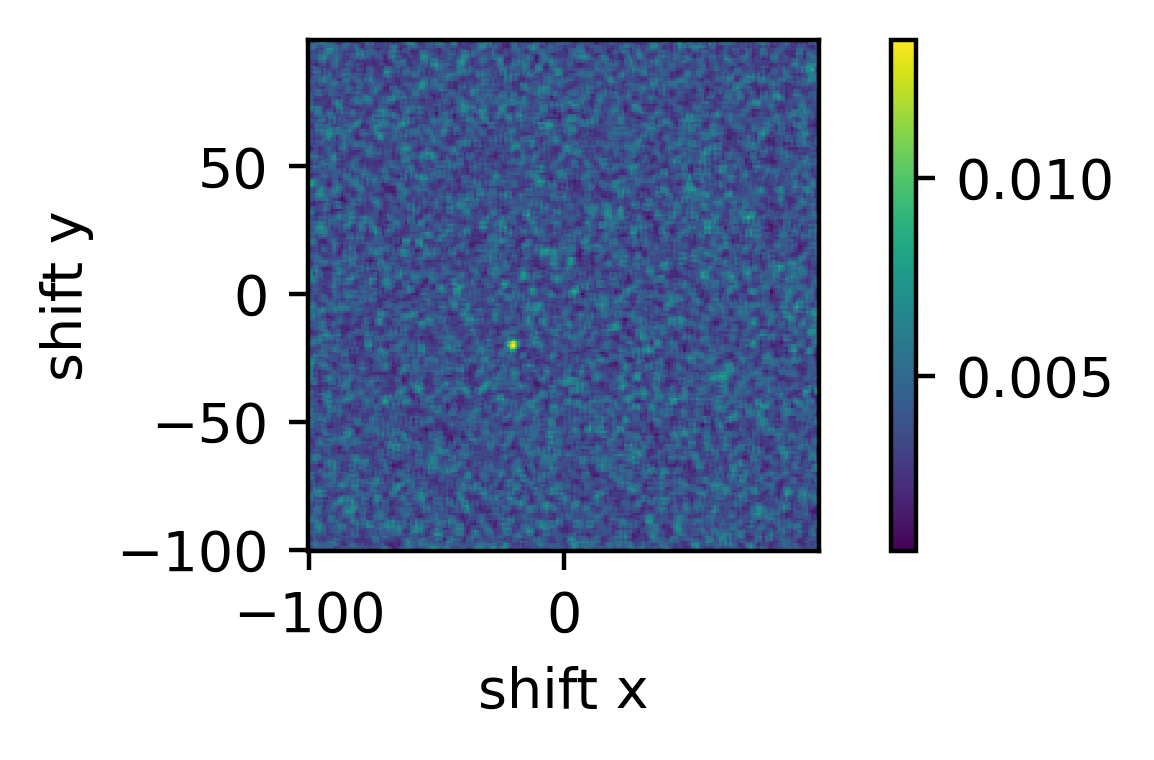

In [648]:
fig = plt.figure(figsize=(4,2), dpi=400)
ax1 = fig.add_subplot(111)
mesh1 = ax1.pcolormesh(x_shift, y_shift, np.abs(r_n_smooth))
ax1.set_xlabel('shift x')
ax1.set_ylabel('shift y')
cbar = fig.colorbar(mesh1, ax=ax1)
plt.gca().set_aspect('equal', adjustable='box')  # force 1:1 scaling
plt.tight_layout()
plt.show()


In [649]:
# find the maximum of the local-mean map
max_idx = np.unravel_index(np.argmax(r_n_smooth), r_n_smooth.shape)

dy = (nx // 2 - max_idx[0])
dx = (ny // 2 - max_idx[1]) 
print('\nEstimated shift X (after smoothing): {} pix\nEstimated shift Y (after smoothing): {} pix'.format(dx, dy))
print('\nTrue shift X: {} pix\nTrue shift Y: {} pix'.format(shift_x, shift_y))


Estimated shift X (after smoothing): 20 pix
Estimated shift Y (after smoothing): 20 pix

True shift X: 20 pix
True shift Y: 20 pix
